# 230968078 - Ishan Suryawanshi - Week2 - Question1

In [1]:
!pip install keras_tuner

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
# removing unnecessary features like row number, customer id, and surname
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [17]:
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [19]:
num_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [20]:
# removing outliers for numerical variables
for i in num_vars:
  q1 = df[i].quantile(0.25)
  q3 = df[i].quantile(0.75)
  iqr = q3 - q1

  lb = q1 - (1.5 * iqr)
  ub = q3 + (1.5 * iqr)

  df = df[(df[i] >= lb) & (df[i] <= ub)]

In [21]:
x = df.drop('Exited', axis=1)
y = df['Exited']

In [22]:
x = pd.get_dummies(x, columns=cat_vars, drop_first=True).astype(int)

In [23]:
# splittig into train test and validation set
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
scaler = StandardScaler()
x_train[num_vars] = scaler.fit_transform(x_train[num_vars])
x_val[num_vars] = scaler.transform(x_val[num_vars])
x_test[num_vars] = scaler.transform(x_test[num_vars])

In [35]:
def build_model(hp):
  model = Sequential()
  num_layers = hp.Choice('layers', [1, 2, 3])
  reg_type = hp.Choice('regularization', ['none', 'l1', 'l2'])
  if reg_type == 'l1':
    reg = regularizers.l1(0.01)
  elif reg_type == 'l2':
    reg = regularizers.l2(0.01)
  else:
    reg = None

  model.add(Dense(128, activation='relu', kernel_regularizer=reg, input_shape=(11,)))
  if num_layers >= 2:
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
  if num_layers == 3:
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
  model.add(Dense(1, activation='sigmoid'))

  lr = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
  model.compile(
      optimizer = Adam(learning_rate=lr),
      loss = 'binary_crossentropy',
      metrics=['accuracy']
  )
  return model

In [36]:
results = []

for ep in [10, 20, 30]:
  tuner = kt.BayesianOptimization(
      build_model,
      objective='val_accuracy',
      max_trials=10,
      executions_per_trial=1,
      overwrite=True
  )

  tuner.search(
      x_train, y_train,
      validation_data=(x_val, y_val),
      epochs=ep,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
      verbose=1
  )

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  best_model = tuner.get_best_models(num_models=1)[0]
  _, best_val_acc = best_model.evaluate(x_val, y_val, verbose=0)

  results.append({
        "epochs": ep,
        "layers": best_hps.get("layers"),
        "regularization": best_hps.get("regularization"),
        "learning_rate": best_hps.get("learning_rate"),
        "val_accuracy": best_val_acc
    })

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.8578892350196838

Best val_accuracy So Far: 0.8578892350196838
Total elapsed time: 00h 01m 25s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
results

[{'epochs': 10,
  'layers': 2,
  'regularization': 'none',
  'learning_rate': 0.01,
  'val_accuracy': 0.8578892350196838},
 {'epochs': 20,
  'layers': 1,
  'regularization': 'none',
  'learning_rate': 0.01,
  'val_accuracy': 0.8599790930747986},
 {'epochs': 30,
  'layers': 2,
  'regularization': 'none',
  'learning_rate': 0.01,
  'val_accuracy': 0.8578892350196838}]

In [38]:
# we can see that we got the best results from choosing 20 epochs
best_result = max(results, key=lambda x: x['val_accuracy'])

In [39]:
best_result

{'epochs': 20,
 'layers': 1,
 'regularization': 'none',
 'learning_rate': 0.01,
 'val_accuracy': 0.8599790930747986}

In [40]:
history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=best_result['epochs'],
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8656 - loss: 0.3362 - val_accuracy: 0.8610 - val_loss: 0.3540
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8619 - loss: 0.3283 - val_accuracy: 0.8454 - val_loss: 0.3683
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8599 - loss: 0.3311 - val_accuracy: 0.8464 - val_loss: 0.3670
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8642 - loss: 0.3312 - val_accuracy: 0.8558 - val_loss: 0.3608


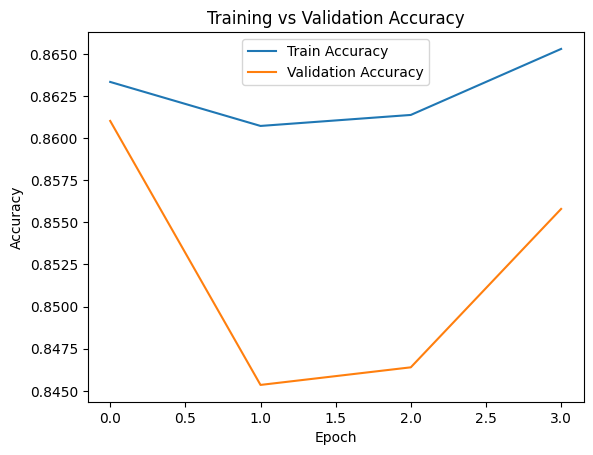

In [41]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [43]:
y_pred = best_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [44]:
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\n===== Test Set Metrics =====")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-score:  {test_f1:.4f}")


===== Test Set Metrics =====
Accuracy:  0.8527
Precision: 0.8313
Recall:    0.3520
F1-score:  0.4946
